In [1]:
import sys
from pathlib import Path
#------------ Define the path to the folder containing your scripts
scripts_path = Path("/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/scripts").resolve()
#------------ Add this path to sys.path if it's not already included
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))
    
from train import*
from data_processing import*
from model import Model
from data_loader import*
from packages import*

# Predicting a Single Basin

In [2]:
# ---------------------------
# Configuration Parameters
# ---------------------------
basin = '01022500'            # 8-digit basin ID from the CAMELS dataset (modifiable)
hidden_size = 10              # Number of LSTM cells in the model
dropout_rate = 0.0            # Dropout rate for the final fully connected layer (0.0 to 1.0)
learning_rate = 1e-3          # Learning rate for the optimizer
sequence_length = 365         # Length (in days) of the meteorological record for each sample

# ---------------------------
# Dataset Setup
# ---------------------------
# Define date ranges for each dataset partition

# Training Data: from October 1, 1980 to September 30, 1995.
train_start_date = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
train_end_date = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
ds_train = CamelsTXT(basin, seq_length=sequence_length, period="train", dates=[train_start_date, train_end_date])
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)

# For evaluation datasets, use the training means and standard deviations for normalization.
means = ds_train.get_means()
stds = ds_train.get_stds()

# Validation Data: from October 1, 1995 to September 30, 2000.
val_start_date = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
val_end_date = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
ds_val = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[val_start_date, val_end_date],
                   means=means, stds=stds)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)

# Test Data: from October 1, 2000 to September 30, 2010.
test_start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
test_end_date = pd.to_datetime("2010-09-30", format="%Y-%m-%d")
ds_test = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[test_start_date, test_end_date],
                    means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)

In [3]:
# ---------------------------
# Model, Optimizer, and Loss Setup
# ---------------------------
# Initialize the LSTM model with the specified parameters and move it to the appropriate device.
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)

# Setup the optimizer (Adam) for training the model.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Mean Squared Error.
loss_func = nn.MSELoss()

# ---------------------------
# Summary and Debug Information
# ---------------------------
print("Configuration:")
print(f" Basin ID: {basin}")
print(f" Sequence length: {sequence_length}")
print(f" Hidden size: {hidden_size}")
print(f" Dropout rate: {dropout_rate}")
print(f" Learning rate: {learning_rate}")
print(f" Training period: {train_start_date.date()} to {train_end_date.date()}")
print(f" Validation period: {val_start_date.date()} to {val_end_date.date()}")
print(f" Test period: {test_start_date.date()} to {test_end_date.date()}")
print("\nModel summary:")
print(model)

Configuration:
 Basin ID: 01022500
 Sequence length: 365
 Hidden size: 10
 Dropout rate: 0.0
 Learning rate: 0.001
 Training period: 1980-10-01 to 1995-09-30
 Validation period: 1995-10-01 to 2000-09-30
 Test period: 2000-10-01 to 2010-09-30

Model summary:
Model(
  (lstm): LSTM(5, 10, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [5]:
# Number of epochs
n_epochs = 20

# Lists to store metrics for each epoch
train_loss_list = []
val_loss_list = []
val_nse_list = []

for epoch in range(n_epochs):
    # ---------------------------
    # Training Phase
    # ---------------------------
    model.train()
    running_train_loss = 0.0
    for xs, ys in tr_loader:
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        optimizer.zero_grad()
        predictions = model(xs)
        loss = loss_func(predictions, ys)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xs.size(0)
    epoch_train_loss = running_train_loss / len(ds_train)
    train_loss_list.append(epoch_train_loss)
    
    # ---------------------------
    # Validation Phase (Loss)
    # ---------------------------
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xs, ys in val_loader:
            xs, ys = xs.to(DEVICE), ys.to(DEVICE)
            predictions = model(xs)
            loss = loss_func(predictions, ys)
            running_val_loss += loss.item() * xs.size(0)
    epoch_val_loss = running_val_loss / len(ds_val)
    val_loss_list.append(epoch_val_loss)
    
    # ---------------------------
    # Validation Phase (NSE)
    # ---------------------------
    # Evaluate on the validation set using the eval_model function
    obs, preds = eval_model(model, val_loader)
    preds = ds_val.local_rescale(preds.numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    val_nse_list.append(nse)
    
    # Print epoch metrics
    tqdm.tqdm.write(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_train_loss:.4f} - Validation NSE: {nse:.2f}")

Epoch 1/20 - Train Loss: 1.0175 - Validation NSE: 0.03
Epoch 2/20 - Train Loss: 0.9456 - Validation NSE: 0.11
Epoch 3/20 - Train Loss: 0.8747 - Validation NSE: 0.19
Epoch 4/20 - Train Loss: 0.8020 - Validation NSE: 0.26
Epoch 5/20 - Train Loss: 0.7101 - Validation NSE: 0.35
Epoch 6/20 - Train Loss: 0.6027 - Validation NSE: 0.46
Epoch 7/20 - Train Loss: 0.5092 - Validation NSE: 0.52
Epoch 8/20 - Train Loss: 0.4667 - Validation NSE: 0.56
Epoch 9/20 - Train Loss: 0.4361 - Validation NSE: 0.57
Epoch 10/20 - Train Loss: 0.4127 - Validation NSE: 0.59
Epoch 11/20 - Train Loss: 0.3928 - Validation NSE: 0.60
Epoch 12/20 - Train Loss: 0.3781 - Validation NSE: 0.61
Epoch 13/20 - Train Loss: 0.3655 - Validation NSE: 0.61
Epoch 14/20 - Train Loss: 0.3558 - Validation NSE: 0.63
Epoch 15/20 - Train Loss: 0.3479 - Validation NSE: 0.63
Epoch 16/20 - Train Loss: 0.3385 - Validation NSE: 0.63
Epoch 17/20 - Train Loss: 0.3302 - Validation NSE: 0.65
Epoch 18/20 - Train Loss: 0.3225 - Validation NSE: 0.65
E

In [6]:
model_path = "/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/notebooks/single_basin/saved_model"
# Define the full path for the saved model weights
model_save_path = model_path+"/model_weights.pth"
# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved as '{model_save_path}'.")

Model saved as '/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/notebooks/single_basin/saved_model/model_weights.pth'.


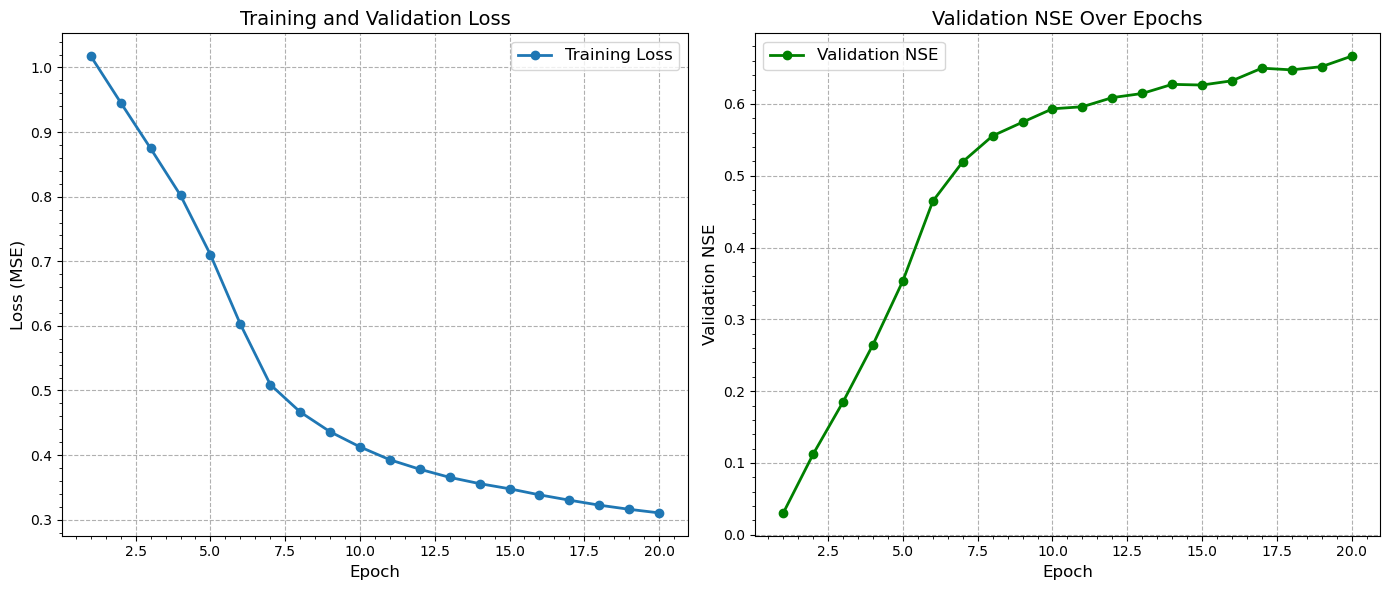

In [7]:
# Assuming epochs, train_loss_list, val_loss_list, and val_nse_list are defined:
epochs = range(1, n_epochs + 1)

# Create one figure with two subplots side by side
plt.figure(figsize=(14, 6))

# ---------------------------
# Training and Validation Loss
# ---------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label="Training Loss", marker='o', linewidth=2)
# plt.plot(epochs, val_loss_list, label="Validation Loss", marker='o', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--')
plt.minorticks_on()

# ---------------------------
# Validation NSE
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, val_nse_list, label="Validation NSE", marker='o', linewidth=2, color='green')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation NSE", fontsize=12)
plt.title("Validation NSE Over Epochs", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--')
plt.minorticks_on()
plt.tight_layout()
plt.show()


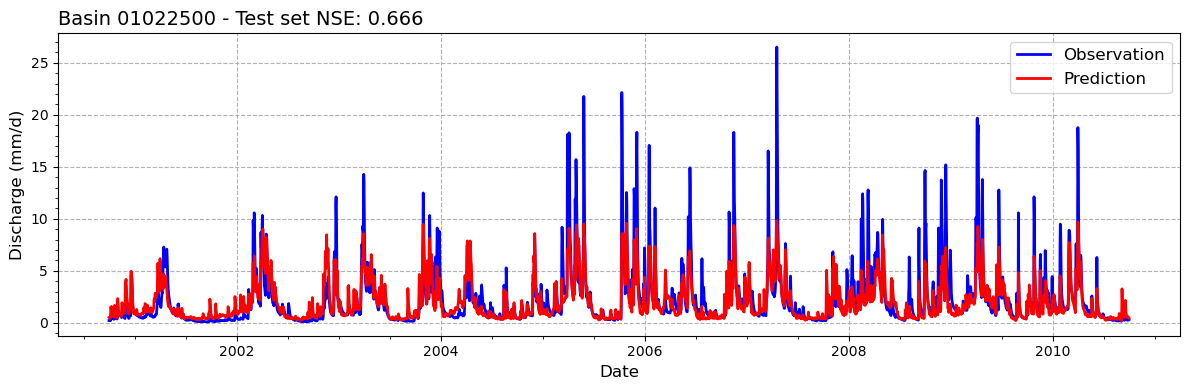

In [9]:
# Evaluate the model on the test set
obs, preds = eval_model(model, test_loader)
preds = ds_val.local_rescale(preds.numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)

# Create a date range for plotting based on the test set dates
start_date = ds_test.dates[0]
end_date = ds_test.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)

# Generate a standard time series plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(date_range, obs, label="Observation", lw=2, color="blue")
ax.plot(date_range, preds, label="Prediction", lw=2, color="red")
ax.set_title(f"Basin {basin} - Test set NSE: {nse:.3f}", fontsize=14, loc = "left")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Discharge (mm/d)", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='x')
ax.minorticks_on()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

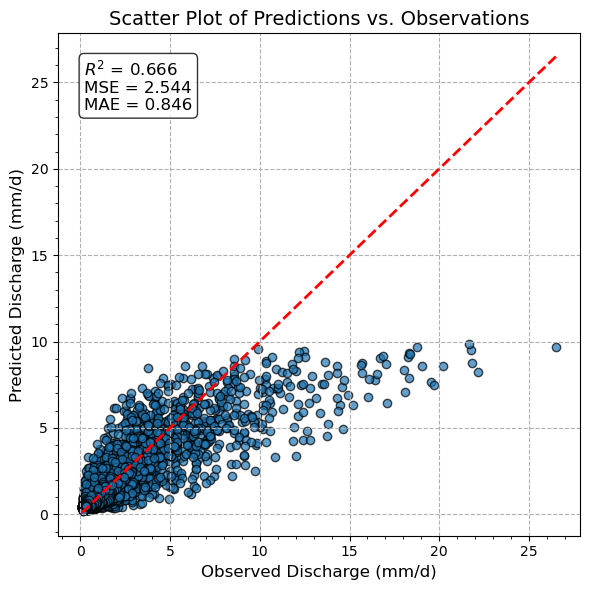

In [10]:
# --- Scatter Plot of Predictions vs. Observations ---
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate metrics
r2 = r2_score(obs, preds)
mse = mean_squared_error(obs, preds)
mae = mean_absolute_error(obs, preds)

# --- Figure 2: Scatter Plot of Predictions vs. Observations ---
fig2, ax2 = plt.subplots(figsize=(6, 6))
ax2.scatter(obs, preds, alpha=0.7, edgecolor='k')

# Plot a 1:1 line for reference
min_val = np.min([obs.min(), preds.min()])
max_val = np.max([obs.max(), preds.max()])
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# Set axis labels and title
ax2.set_xlabel("Observed Discharge (mm/d)", fontsize=12)
ax2.set_ylabel("Predicted Discharge (mm/d)", fontsize=12)
ax2.set_title("Scatter Plot of Predictions vs. Observations", fontsize=14)
ax2.minorticks_on()
ax2.grid()

# Annotate the plot with metrics inside the plot area
metrics_text = f"$R^2$ = {r2:.3f}\nMSE = {mse:.3f}\nMAE = {mae:.3f}"
ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig2.tight_layout()
plt.grid(True, linestyle='--')
plt.show()


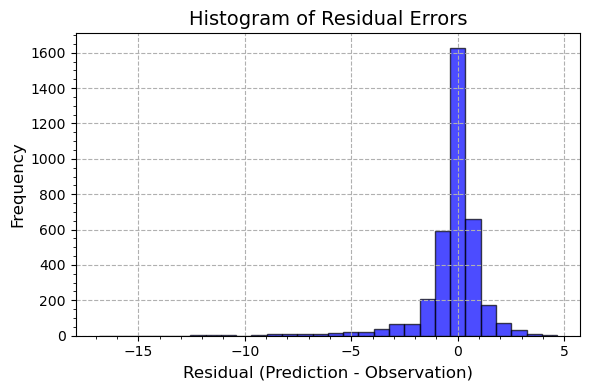

In [11]:
# --- Histogram of Residual Errors ---
residuals = preds - obs
fig3, ax3 = plt.subplots(figsize=(6, 4))
ax3.hist(residuals, bins=30, color='blue', edgecolor='k', alpha=0.7)
ax3.set_xlabel("Residual (Prediction - Observation)", fontsize=12)
ax3.set_ylabel("Frequency", fontsize=12)
ax3.set_title("Histogram of Residual Errors", fontsize=14)
ax3.minorticks_on()
fig3.tight_layout()
plt.grid(True, linestyle='--')
plt.show()

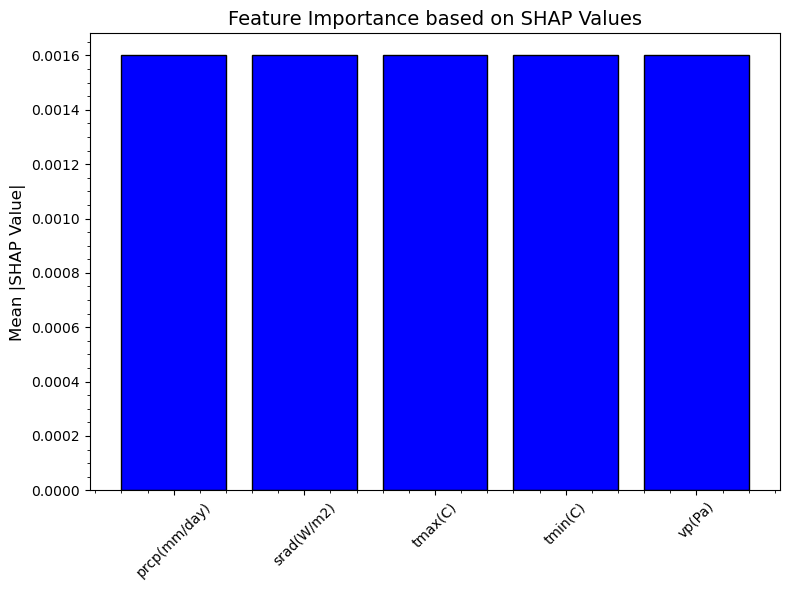

In [12]:
# ------------------------------
# SHAP Explanation for the Model
# ------------------------------

# Select a subset of training samples as the background for SHAP.
# ds_train.x is assumed to be a torch.Tensor of shape (N, sequence_length, features)
background = ds_train.x[:50].to(DEVICE)

# Select some test samples for explanation (e.g., first 50 samples)
X_test = ds_test.x[:100].to(DEVICE)

# Create a DeepExplainer using the background samples.
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the test samples.
# Set check_additivity=False to bypass the additivity check.
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Extract the array from the list. The shape is (n_samples, sequence_length, n_features).
shap_vals = shap_values[0]
if isinstance(shap_vals, torch.Tensor):
    shap_vals = shap_vals.detach().cpu().numpy()

# Aggregate SHAP values over the time (sequence) dimension:
# Average the absolute SHAP values over the sequence length for each feature.
abs_shap = np.abs(shap_vals).mean(axis=1)  # Shape: (n_samples, n_features)
# Then average over all samples to get one value per feature.
mean_shap_per_feature = abs_shap.mean(axis=0)  # Shape: (n_features,)

# Define feature names corresponding to your input features.
feature_names = ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'vp(Pa)']

# ------------------------------
# Plot the SHAP Feature Importances
# ------------------------------
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(feature_names, mean_shap_per_feature, color='blue', edgecolor='k')
ax.set_ylabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance based on SHAP Values', fontsize=14)
ax.minorticks_on()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Perform Transfer Learning on Another Basin

In [15]:
# ---------------------------
# Load the Pretrained Model
# ---------------------------
# Create a new model instance with the same architecture and load the saved weights.
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)

model.load_state_dict(torch.load(model_save_path))
model.eval()
print(f"Pretrained model loaded from {model_save_path}")

Pretrained model loaded from /Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/notebooks/single_basin/saved_model/model_weights.pth


Transfer Learning: New Basin 13310700 - NSE: -0.528


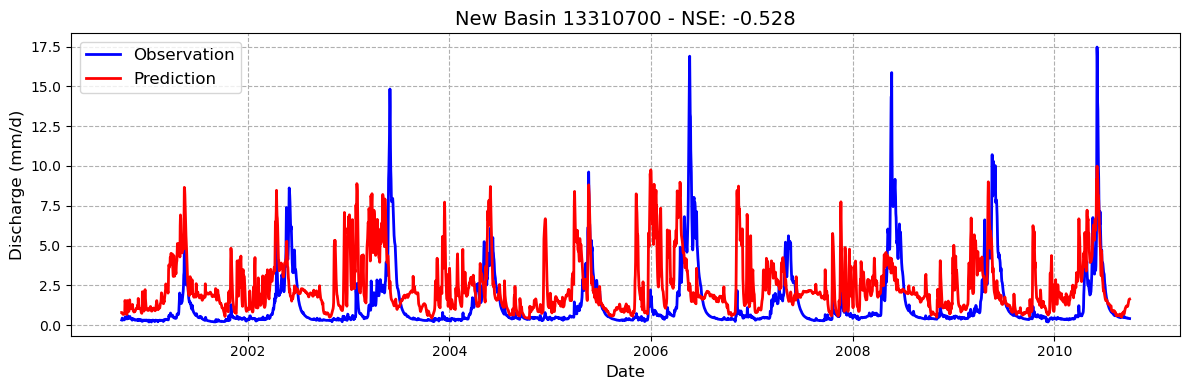

In [21]:
# ---------------------------
# Prepare New Basin Dataset for Transfer Learning
# ---------------------------
# Define the new basin ID and date range for prediction (adjust as needed).
new_basin = '13310700'  # Example: new basin id for transfer learning
new_start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
new_end_date = pd.to_datetime("2010-09-30", format="%Y-%m-%d")

# For transfer, you can choose to use the normalization parameters (means/stds) from the original basin,
# or recalculate them using training data from the new basin.
# Here we use the same means and stds from the original training set.
new_ds = CamelsTXT(new_basin, seq_length=sequence_length, period="eval",
                   dates=[new_start_date, new_end_date], means=means, stds=stds)
new_loader = DataLoader(new_ds, batch_size=2048, shuffle=False)

# ---------------------------
# Evaluate the Model on the New Basin
# ---------------------------
# Get predictions using the pretrained model.
obs_new, preds_new = eval_model(model, new_loader)
# Rescale predictions to the original discharge units.
preds_new = new_ds.local_rescale(preds_new.numpy(), variable='output')
obs_new = obs_new.numpy()
nse_new = calc_nse(obs_new, preds_new)
print(f"Transfer Learning: New Basin {new_basin} - NSE: {nse_new:.3f}")

# ---------------------------
# Plot Predictions for the New Basin
# ---------------------------
# Create a date range for plotting.
start_date = new_ds.dates[0]
end_date = new_ds.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)

plt.figure(figsize=(12, 4))
plt.plot(date_range, obs_new, label="Observation", lw=2, color="blue")
plt.plot(date_range, preds_new, label="Prediction", lw=2, color="red")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Discharge (mm/d)", fontsize=12)
plt.title(f"New Basin {new_basin} - NSE: {nse_new:.3f}", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--")
plt.xticks()
plt.tight_layout()
plt.show()


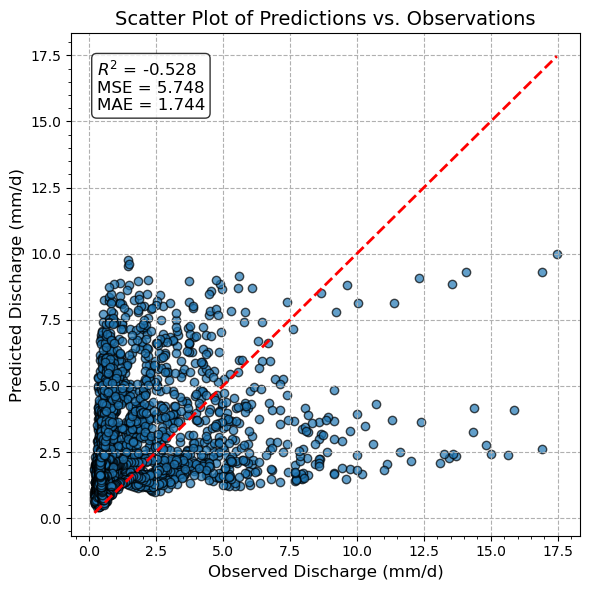

In [20]:
# Calculate metrics
r2 = r2_score(obs_new, preds_new)
mse = mean_squared_error(obs_new, preds_new)
mae = mean_absolute_error(obs_new, preds_new)

# --- Figure 2: Scatter Plot of Predictions vs. Observations ---
fig2, ax2 = plt.subplots(figsize=(6, 6))
ax2.scatter(obs_new, preds_new, alpha=0.7, edgecolor='k')

# Plot a 1:1 line for reference
min_val = np.min([obs_new.min(), preds_new.min()])
max_val = np.max([obs_new.max(), preds_new.max()])
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# Set axis labels and title
ax2.set_xlabel("Observed Discharge (mm/d)", fontsize=12)
ax2.set_ylabel("Predicted Discharge (mm/d)", fontsize=12)
ax2.set_title("Scatter Plot of Predictions vs. Observations", fontsize=14)
ax2.minorticks_on()
ax2.grid()

# Annotate the plot with metrics inside the plot area
metrics_text = f"$R^2$ = {r2:.3f}\nMSE = {mse:.3f}\nMAE = {mae:.3f}"
ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig2.tight_layout()
plt.grid(True, linestyle='--')
plt.show()